In [1]:
# Import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Dimensions
latent_size = 64
hidden_size = 256
image_size = 784 # 28x28
num_epochs = 200
batch_size = 100
learning_rate = 0.0002

In [4]:
# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [5]:
# Download MNIST dataset
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Set dataloader
dataloader = torch.utils.data.DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8110477.59it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 277512.73it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2533544.12it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1140340.52it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
# Discriminator model
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
).to(device)

In [7]:
# Generator model
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

In [8]:
# Optimization algorithm
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)

In [9]:
# Real label
def real_labels(size):
    return torch.ones(size, 1).to(device)

# Fake label
def fake_labels(size):
    return torch.zeros(size, 1).to(device)

Epoch [20/200], d_loss: 0.1797, g_loss: 5.2994


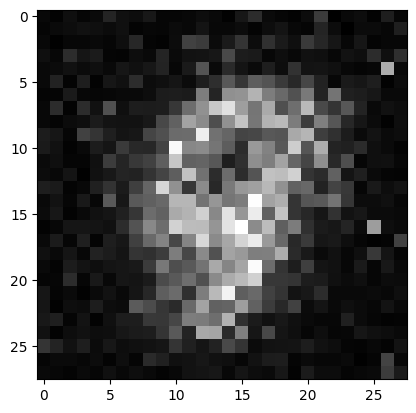

Epoch [40/200], d_loss: 0.4822, g_loss: 4.2533


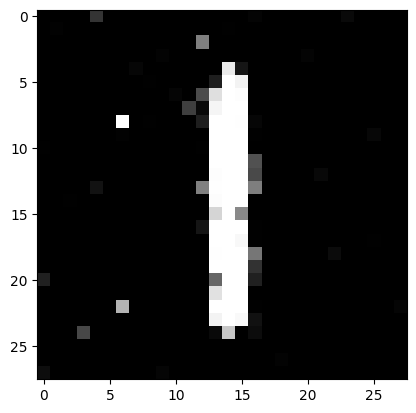

Epoch [60/200], d_loss: 0.5040, g_loss: 2.4289


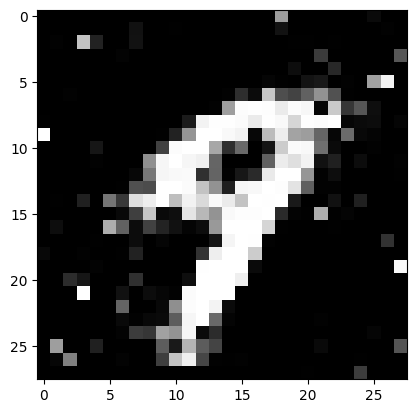

Epoch [80/200], d_loss: 0.6472, g_loss: 3.2003


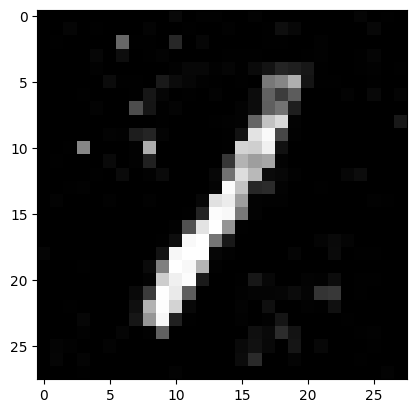

Epoch [100/200], d_loss: 0.8119, g_loss: 1.8712


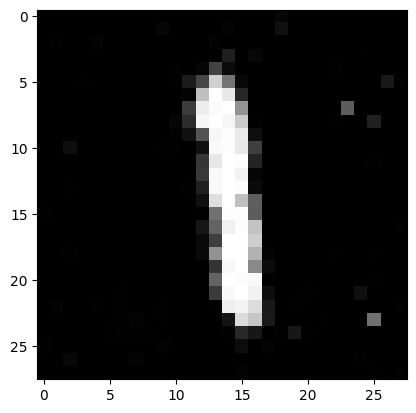

Epoch [120/200], d_loss: 1.0253, g_loss: 1.6207


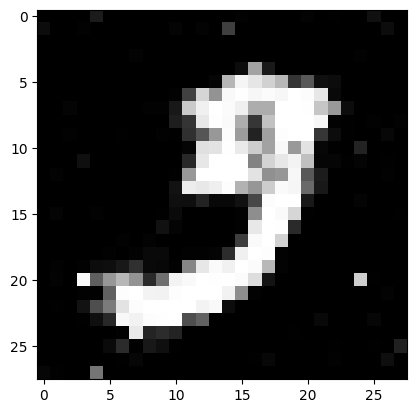

Epoch [140/200], d_loss: 0.8508, g_loss: 1.4957


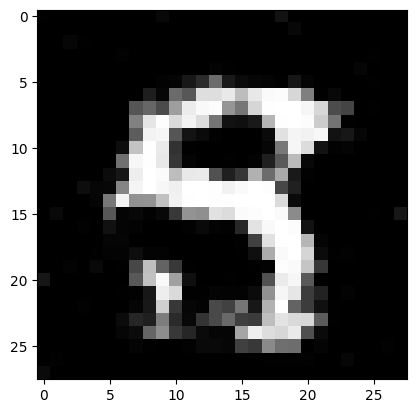

Epoch [160/200], d_loss: 0.9921, g_loss: 1.2771


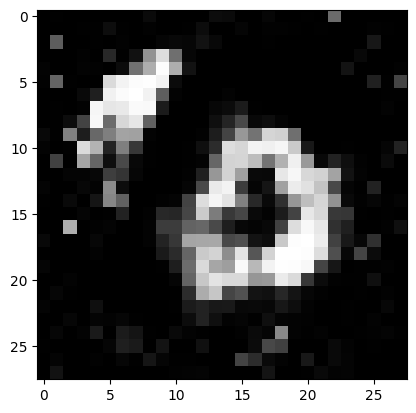

Epoch [180/200], d_loss: 0.8844, g_loss: 1.4094


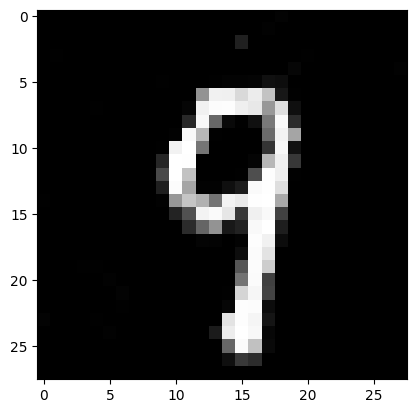

Epoch [200/200], d_loss: 1.0684, g_loss: 1.2850


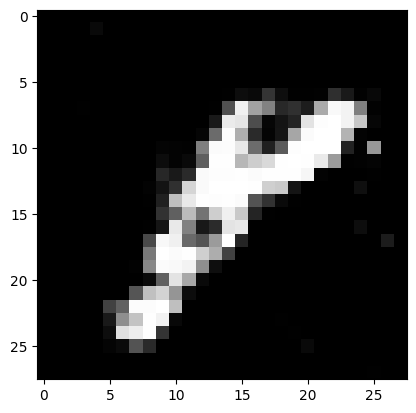

In [10]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        # Flatten images to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Create labels
        real = real_labels(batch_size)
        fake = fake_labels(batch_size)

        # Train Discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real)
        real_score = outputs

        z = torch.randn(batch_size,latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels(batch_size))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Print generator's images
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        plt.imshow(fake_images[0].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.show()

In [13]:
# Save the generator and discriminator
torch.save(G.state_dict(), 'mnist_generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

print("Models saved successfully!")


Models saved successfully!
